In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import MonthLocator

<class 'pandas.core.frame.DataFrame'>
Index: 405 entries, 2023-11-26 to 2023-07-07
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   valid    405 non-null    int64  
 1   invalid  364 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 9.5+ KB
            valid  invalid
arr_date                  
2023-11-26    177      NaN
2022-12-20    804   1800.0
2022-10-25    844   1731.0
2022-10-18    853   1456.0
2022-10-26    866   1766.0
...           ...      ...
2023-07-06   2346   1015.0
2023-07-05   2383   1129.0
2023-07-08   2394    997.0
2023-07-02   2401   1168.0
2023-07-07   2413   1014.0

[405 rows x 2 columns]


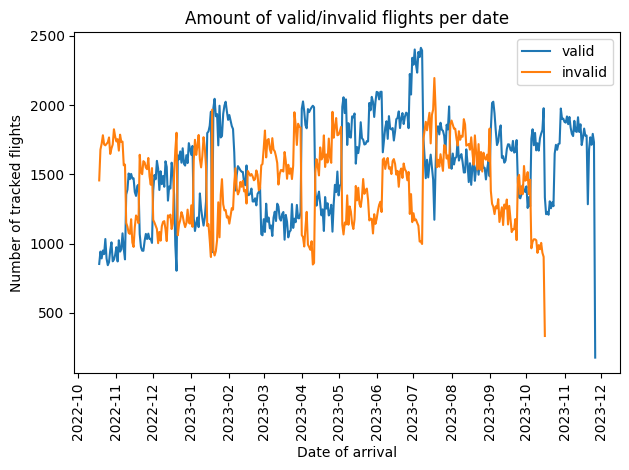

In [3]:
def group_by_date(df):
    df['arr_date'] = pd.to_datetime(df['arr_time_utc']).dt.date
    df = df.groupby(['arr_date']).size().sort_values(ascending=True).reset_index(name='counts')
    df.set_index('arr_date', inplace=True)
    return df


def analyze_records_by_day():
    valid_flights = pd.read_csv("../extract/data/history/flightsHistory_2022-10-18_to_2023-11-25-holidays.csv")
    invalid_flights = pd.read_csv("../extract/data/history/flightsHistory_invalid_2022-10-18_to_2023-11-25-holidays")
    valid_flights = group_by_date(valid_flights).rename(columns={"counts": "valid"})
    invalid_flights = group_by_date(invalid_flights).rename(columns={"counts": "invalid"})
    flights = pd.merge(valid_flights, invalid_flights, how='outer', on='arr_date')
    flights.info()
    print(flights.head(500))
    ax = flights.plot()
    ax.xaxis.set_major_locator(MonthLocator())
    plt.xticks(rotation=90)
    plt.title("Amount of valid/invalid flights per date")
    plt.ylabel("Number of tracked flights")
    plt.xlabel("Date of arrival")
    plt.tight_layout()
    plt.show()

analyze_records_by_day()